# <span style="color:#F72585"><center>Tutorial Pyro</center></span>


## <span style="color:#4361EE">Introducción</span>


Se introducen los elementos esenciales del uso de Pyro. En este cuaderno usamos el ejemplo de 8 escuelas (eight schools) que utilizamos en el primer ejemplo de Pyro en este curso.

## <span style="color:#4361EE">El modelo estadístico para este tutorial</span>


Supongamos que tenemos observaciones $[y_n |x_n], n=1,\ldots,N$, y asumamos el modelo Bayesiano. 

**Modelo con efectos aleatorios**

- Estima los hiperparámetros $\mu$ and $\tau$
- Predice los efectos aleatorios $\eta_i$


$$
\begin{align}
y_i &\sim \mathcal{N}(\theta_i,\sigma_i^2), \text{ known } \sigma_i^2\\
\theta_i & = \mu + \tau \times \eta_i \\
\eta_i &\sim \mathcal{N}(0, 1)\\
\mu &\propto 1\\
\tau &\propto 1
\end{align}
$$


### <span style="color:#4CC9F0">Los datos</span>


Los datos corresponden a la estimación (estandarizada) de un puntaje realizada en las ocho escuelas observadas. Este ejemplo es tratado en {cite}`gelman1995bayesian`


```{table}
|School |Estim. Treatment Effect | Estim. Stand. Error |
|---|---|---|
|A |28| 15|
|B |8 |10|
|C| -3| 16|
|D| 7| 11|
|E| -1 |9|
|F| 1| 11|
|G |18| 10|
|H| 12| 18|
```

In [2]:
# Importamos las librerías necesarias
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import torch
import data
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS

In [3]:
# Los datos
J = 8 #Número de escuelas
y = torch.tensor([28, 8, -3, 7, -1, 1, 18, 12]).type(torch.Tensor) #Estimaciones de los efectos del tratamiento
sigma = torch.tensor([15, 10, 16, 11, 9, 11, 10, 18]).type(torch.Tensor) #Estimacion de la desviacion de los efectos del tratamiento
schools = np.array(['Choate', 'Deerfield', 'Phillips Andover', 'Phillips Exeter',
                    'Hotchkiss', 'Lawrenceville', "St. Paul's", 'Mt. Hermon'])

schools_dat = {'J': J,
               'y': y,
               'sigma': sigma}
schools_dat 

{'J': 8,
 'y': tensor([28.,  8., -3.,  7., -1.,  1., 18., 12.]),
 'sigma': tensor([15., 10., 16., 11.,  9., 11., 10., 18.])}

## <span style="color:#4361EE">Implementación del modelo estadístico en Pyro</span>

In [19]:
def model(sigma):
    eta = pyro.sample("eta", dist.Normal(torch.zeros(sigma.numel()), torch.ones(sigma.numel())))
    mu = pyro.param("mu", lambda: torch.ones(()))
    tau = pyro.param("tau", lambda: torch.ones(()))
    theta = mu + tau * eta

    return pyro.sample("obs", dist.Normal(theta, sigma))


def conditioned_model(model, sigma, y):
    return poutine.condition(model, data={"obs": y})(sigma)

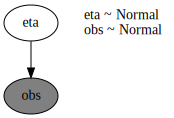

In [20]:
pyro.render_model(conditioned_model, model_args=(model,sigma,y), render_distributions=True)

En este código los prámetros que serán muestreados son los $\eta_i$ (*eta*) que son los efectos aleatorios en el modelo. Las medias $\theta_i$ de las escuelas son calculados. Es decir, son funcionales de los parámetros.

## <span style="color:#4361EE">Compilación del modelo</span>


In [21]:
nuts_kernel = NUTS(conditioned_model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=300)
mcmc.run(model,sigma,y)

Sample: 100%|██████████| 800/800 [00:17, 44.60it/s, step size=7.30e-01, acc. prob=0.891]


In [22]:
 mcmc.summary(prob=0.5)



                mean       std    median     25.0%     75.0%     n_eff     r_hat
    eta[0]      0.08      0.94      0.11     -0.64      0.58    708.86      1.00
    eta[1]     -0.01      0.97      0.02     -0.62      0.64    696.02      1.00
    eta[2]      0.00      0.99     -0.00     -0.74      0.56    549.42      1.00
    eta[3]      0.07      1.06      0.05     -0.70      0.63   1064.58      1.00
    eta[4]     -0.01      0.95     -0.03     -0.69      0.53    636.25      1.00
    eta[5]     -0.05      1.01     -0.04     -0.77      0.48    732.73      1.00
    eta[6]      0.12      1.01      0.12     -0.44      0.87   1050.38      1.00
    eta[7]      0.12      0.96      0.12     -0.46      0.81    929.51      1.00

Number of divergences: 0


Una vez el modelo es compilado, se pueden generar muestras cuando se desee.

In [23]:
samples=mcmc.get_samples()
samples

{'eta': tensor([[-2.6222e-01, -3.2064e-01, -1.6875e+00,  ..., -8.0678e-02,
           1.2697e+00, -1.3694e+00],
         [ 3.4974e-01, -1.4623e-02,  2.2432e+00,  ..., -2.9391e-01,
           4.4630e-01,  1.5364e+00],
         [ 1.5182e-01,  5.8864e-01, -1.3440e+00,  ..., -1.3726e+00,
           3.5196e-01,  6.9789e-01],
         ...,
         [-6.3459e-04,  9.9026e-01, -1.4215e+00,  ..., -2.2663e-02,
           1.5219e+00, -3.9298e-02],
         [-7.5880e-02, -1.2516e+00,  2.2384e+00,  ..., -8.1932e-01,
           7.1641e-02,  1.8300e-01],
         [ 7.6357e-01,  1.1549e+00,  3.0067e-01,  ...,  1.3074e-01,
          -6.5471e-01, -9.3799e-01]])}